<a href="https://colab.research.google.com/github/anyuanay/dsr_n2c2/blob/main/notebooks/NER_BiLSTM_CRF_example_disease_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Named Entity Recognition Using Deep Neural Networks (DNN) and Conditional Random Fields (CRF): 
## References:
1. https://www.nexsoftsys.com/articles/overview-of-named-entity-recognition-using-crf.html : A brief overview using DNN and CRF. We will use its dataset for disease recognition.
2. https://utkarsh-kumar2407.medium.com/named-entity-recognition-using-bidirectional-lstm-crf-9f4942746b3c: Includes Python code for NER
3. https://medium.com/data-science-in-your-pocket/named-entity-recognition-ner-using-conditional-random-fields-in-nlp-3660df22e95c: Introduction to CRF NER
4. Bidirectional LSTM-CRF Models for Sequence Tagging: https://arxiv.org/abs/1508.01991

## BIO Annotation for NER
Tags of entities are encoded in a BIO-annotation scheme. Each entity is labeled with a B or an I to detect multi-word entities, where B denotes the beginning of an entity and I denote the inside of an entity. O denotes all other words which are not named entities.

## Download the Data
1. Download the data from: https://www.dropbox.com/s/ef5g11fdq7igi74/hackathon_disease_extraction.zip?dl=0
2. Extract the data sets into your Google Drive under 'MyDrive/Colab Notebooks/n2c2/'

## Importing Libraries

In [1]:
# Install extra-dependencies
! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite

     |████████████████████████████████| 743 kB 9.7 MB/s 


In [82]:
# Use tensorflow 1.x to work with keras-contrib CRF
%tensorflow_version 1.x

In [3]:
## Importing all required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


In [5]:
import tensorflow as tf

In [7]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

## Loading Data

In [8]:
## Loading data 
train_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/n2c2/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/n2c2/test.csv")

In [9]:
train_data.head()

,id,Doc_ID,Sent_ID,Word,tag
0,1,1,1,Obesity,O
1,2,1,1,in,O
2,3,1,1,Low-,O
3,4,1,1,and,O
4,5,1,1,Middle-Income,O


In [10]:
test_data.head()

,id,Doc_ID,Sent_ID,Word
0,4543834,30001,191283,CCCVA
1,4543835,30001,191283,","
2,4543836,30001,191283,MANOVA
3,4543837,30001,191283,","
4,4543838,30001,191283,my


## Exploring the Data

In [11]:
train_data.tag.unique()

array(['O', 'B-indications', 'I-indications'], dtype=object)

In [12]:
## Getting the list of words
words = list(set(train_data["Word"].append(test_data["Word"]).values))
n_words = len(words)
n_words, words[20:23]

(257202, ['0.712', 'axle', 'determinaram'])

In [13]:
words[:4]

['textual', nan, 'lithophages', 'stabilometric']

In [14]:
## Creating the list of tags
tags = list(set(train_data["tag"].values))
n_tags = len(tags)
n_tags

3

## Constructing Sentences as Lists of (word, tag) Tuples

In [15]:
word_tag_func = lambda s: [(word,tag) for word, tag in zip(s["Word"].values, s["tag"].values)]
grouped_word_tag = train_data.groupby("Sent_ID").apply(word_tag_func)
sentences = [s for s in grouped_word_tag]

word_tag_func = lambda s: [word for word in s["Word"].values]
grouped_word = test_data.groupby("Sent_ID").apply(word_tag_func )
test_sentences = [s for s in grouped_word]

In [16]:
# print a sentence with a disease and having more than 10 words
stop = False
for sent in sentences:
    if stop == False:
        for tup in sent:
            if tup[1] == 'I-indications':
                if len(sent) > 10:
                    print(sent)
                    stop = True
                    break

[('We', 'O'), ('compared', 'O'), ('the', 'O'), ('inter-day', 'O'), ('reproducibility', 'O'), ('of', 'O'), ('post-occlusive', 'O'), ('reactive', 'B-indications'), ('hyperemia', 'I-indications'), ('(', 'O'), ('PORH', 'O'), (')', 'O'), ('assessed', 'O'), ('by', 'O'), ('single-point', 'O'), ('laser', 'O'), ('Doppler', 'O'), ('flowmetry', 'O'), ('(', 'O'), ('LDF', 'O'), (')', 'O'), ('and', 'O'), ('laser', 'O'), ('speckle', 'O'), ('contrast', 'O'), ('analysis', 'O'), ('(', 'O'), ('LSCI', 'O'), (')', 'O'), (',', 'O'), ('and', 'O'), ('the', 'O'), ('reproducibility', 'O'), ('of', 'O'), ('local', 'O'), ('thermal', 'O'), ('hyperemia', 'O'), ('(', 'O'), ('LTH', 'O'), (')', 'O'), ('assessed', 'O'), ('by', 'O'), ('LDF', 'O'), (',', 'O'), ('laser', 'O'), ('Doppler', 'O'), ('imaging', 'O'), ('(', 'O'), ('LDI', 'O'), (')', 'O'), ('and', 'O'), ('LSCI', 'O'), ('.', 'O')]


## Visualizing the Lengths of the Sentences

In [17]:
# How many sentences
len(sentences)

191282

In [18]:
# Get all lengths
lens = np.array([len(s) for s in sentences])
lens.min(), lens.max()

(1, 3899)

In [19]:
# How many sentences which very long?
(lens > 100).sum()

371

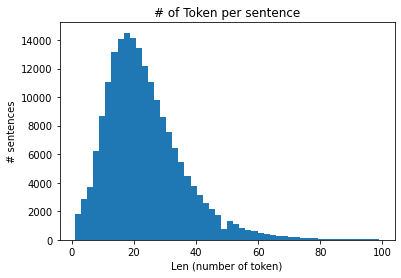

In [20]:
# Plot sentence by length (< 100 tokens)
plt.hist(lens[lens<100], bins=50)
plt.title('# of Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# sentences')
plt.show()

## Pre-processing
Before feeding the data to the model we need to further preprocess the text.
1. We will convert each text word to a corresponding integer ID using the word_idx dictionary. Doing so saves a lot of memory.
2. In order to feed the data to the LSTM-CRF model, we need to ensure that all text should be of the same length. The method sequence.pad_sequences() and variable MAX_LEN are used for this purpose. The text which are shorter than MAX_LEN are padded to get them to the same length, whereas text which are longer than MAX_LEN are truncated. The Tokens per sentence plot (see above) is useful for setting the MAX_LEN training hyperparameter.

In [21]:
## map words to indices and vice versa
word_idx = {word:index+2 for index, word in enumerate(words)}
word_idx["UNK"] = 1 # Unknown words
word_idx["PAD"] = 0 # Padding
# Vocabulary Key:token_index -> Value:word
idx_word = {i: w for w, i in word_idx.items()}

In [22]:
list(word_idx.items())[:4]

[('textual', 2), (nan, 3), ('lithophages', 4), ('stabilometric', 5)]

In [23]:
# map tags to indices and vice versa
tag_idx = {t: i+1 for i, t in enumerate(tags)}
tag_idx["PAD"] = 0
# Vocabulary Key:tag_index -> Value:Label/Tag
idx_tag = {i: w for w, i in tag_idx.items()}

In [24]:
set(tags)

{'B-indications', 'I-indications', 'O'}

In [25]:
print("The word hyperemia is identified by the index: {}".format(word_idx["hyperemia"]))

print("The labels B-indications(which defines disease Enitities) is identified by the index: {}".format(tag_idx["B-indications"]))

The word hyperemia is identified by the index: 117844
The labels B-indications(which defines disease Enitities) is identified by the index: 1


In [26]:
from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X = [[word_idx[w[0]] for w in s] for s in sentences]

# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word_idx["PAD"])

In [27]:
X.shape

(191282, 75)

In [28]:
# Convert Tag/Label to tag_index
y = [[tag_idx[w[1]] for w in s] for s in sentences]

# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag_idx["PAD"])

In [29]:
from tensorflow.keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

In [30]:
len(y), y[0].shape

(191282, (75, 4))

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape, np.array(y_train).shape, np.array(y_test).shape

((153025, 75), (38257, 75), (153025, 75, 4), (38257, 75, 4))

In [32]:
print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[1] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

Raw Sample:  Obesity in Low- and Middle-Income Countries : Burden , Drivers , and Emerging Challenges .
Raw Label:  O O O O O O O O O O O O O O O
After processing, sample: [102099 102105 194405 100500 134007  47427 152140 154868 200000 207069
 200000 100500 147857  88261 171153      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0]
After processing, labels: [[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.

In [33]:
X_finaltest = [[word_idx[w] for w in s] for s in test_sentences]
## Preparing final test data
X_finaltest = pad_sequences(sequences= X_test, maxlen= MAX_LEN, padding='post', value=word_idx["PAD"])
X_finaltest.shape

(38257, 75)

## Modeling
1. Reference: We will use the Keras library to create the Bi-LSTM-CRF model proposed in the paper: Bidirectional LSTM-CRF Models for Sequence Tagging: https://arxiv.org/abs/1508.01991

![bi_LSTM_CRF_NER](https://i.imgur.com/tSNQtfj.png)

In [37]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras_contrib import losses, metrics
# Model definition
input = Input(shape=(MAX_LEN,))
#model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
#                 input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding

model = Embedding(input_dim= n_words+2, output_dim=EMBEDDING, 
                   input_length=MAX_LEN)(input)

model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM

model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf_model = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf_model(model)  # output
model = Model(input, out)
model.compile(optimizer="rmsprop", loss=losses.crf_loss, metrics=[metrics.crf_accuracy])

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 75, 40)            10288160  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 75, 100)           36400     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_3 (CRF)                  (None, 75, 4)             228       
Total params: 10,329,838
Trainable params: 10,329,838
Non-trainable params: 0
_________________________________________________________________


In [38]:
history = model.fit(X_train, np.array(y_train), batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1, verbose=2)


Train on 137722 samples, validate on 15303 samples
Epoch 1/5
 - 56s - loss: 0.0884 - crf_accuracy: 0.9677 - val_loss: 0.0116 - val_crf_accuracy: 0.9952
Epoch 2/5
 - 54s - loss: 0.0065 - crf_accuracy: 0.9960 - val_loss: 0.0036 - val_crf_accuracy: 0.9962
Epoch 3/5
 - 53s - loss: -7.7536e-04 - crf_accuracy: 0.9969 - val_loss: -2.4924e-03 - val_crf_accuracy: 0.9968
Epoch 4/5
 - 54s - loss: -6.2140e-03 - crf_accuracy: 0.9973 - val_loss: -6.9135e-03 - val_crf_accuracy: 0.9968
Epoch 5/5
 - 53s - loss: -1.0953e-02 - crf_accuracy: 0.9976 - val_loss: -1.1188e-02 - val_crf_accuracy: 0.9969


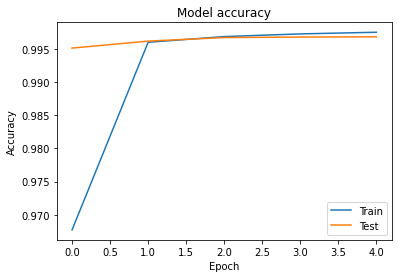

In [42]:
# Plot training & validation accuracy values
plt.plot(history.history['crf_accuracy'])
plt.plot(history.history['val_crf_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

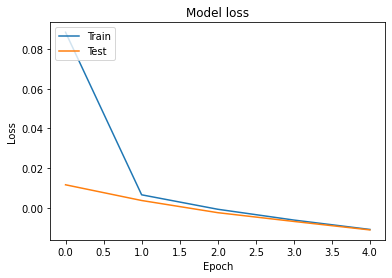

In [41]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [76]:
# Eval
pred_cat = model.predict(X_test)
pred = np.argmax(pred_cat, axis=-1)

In [77]:
y_test_true = np.argmax(y_test, -1)

## Evaluating the Model

In [78]:
from sklearn.metrics import classification_report

# Convert the index to tag
y_pred = [[idx_tag[i] for i in row] for row in pred]
y_true = [[idx_tag[i] for i in row] for row in y_test_true]

In [79]:
len(y_pred), len(y_true)

(75, 75)

In [80]:
y_true_flatten = [ele for sent in y_true for ele in sent]
y_pred_flatten = [ele for sent in y_pred for ele in sent]

In [81]:
report = classification_report(y_true=y_true_flatten, y_pred=y_pred_flatten, labels=None)
print(report)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

B-indications       0.00      0.00      0.00     10655
I-indications       0.00      0.31      0.01      9037
            O       0.30      0.32      0.31    885549
          PAD       0.66      0.34      0.45   1964034

     accuracy                           0.33   2869275
    macro avg       0.24      0.24      0.19   2869275
 weighted avg       0.55      0.33      0.40   2869275



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
i = np.random.randint(0,X_test.shape[0]) # choose a random number between 0 and len(X_te)
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_test.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx_tag[t], idx_tag[pred]))

Sample number 30468 of 38257 (Test Set)
Word           ||True ||Pred
The            : O     PAD
techniques     : O     O
described      : O     I-indications
here           : O     PAD
should         : O     O
help           : O     I-indications
to             : O     PAD
reinvigorate   : O     O
faltering      : O     I-indications
programs       : O     PAD
,              : O     O
giving         : O     I-indications
hospital       : O     PAD
management     : O     O
a              : O     I-indications
chance         : O     PAD
to             : O     PAD
``             : O     O
do             : O     I-indications
it             : O     PAD
right          : O     O
the            : O     I-indications
second         : O     PAD
time           : O     O
.              : O     I-indications
''             : O     PAD
